# Inference Network Training

In [12]:
# Set notebook up to load files from Science repo
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
# Ensure that we re-load changes automagically
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [14]:
import itertools
import json
import pickle
import numpy as np
import pandas as pd
from matplotlib.pylab import plt
import seaborn as sns

# Set random seeds
import random
RANDOM_SEED = 42
random.seed(RANDOM_SEED);
np.random.seed(RANDOM_SEED);
torch.manual_seed(RANDOM_SEED);

OVERWRITE_OLD_TRAINING_DATA = False

### Import and Pre-Process Language

In [15]:
from science.observations.text_analysis import nn_preprocess_chat_phrase
from science.analysis.model_benchmarking import human_human_experiment_dataframe

df = human_human_experiment_dataframe()
df["tokens"] = df.chat_text.apply(lambda x: nn_preprocess_chat_phrase(x))

## Helper Functions

#### Set up Target Vector
Take a reward configuration string and transform it into the appropriate target vector for training.

In [16]:
from science.utils import FEATURE_ABBREVIATION_DICT, FEATURES, CONJUNCTIONS

def reward_vector_from_config(value_mask_config):
    
    sign_config = value_mask_config["color_config"]
    magnitude_config = value_mask_config["shape_config"]
    
    reward_dict = {}
    signs = [-1, 0, 1]
    magnitudes = [2, 5.5, 9]
    
    for s, f1 in zip(signs, sign_config.split("_")):
        for m, f2 in zip(magnitudes, magnitude_config.split("_")):
            feature_name = "{}|{}".format(FEATURE_ABBREVIATION_DICT[f1], FEATURE_ABBREVIATION_DICT[f2])
            reward_dict[feature_name] = s * m / 10
    
    # Build a series with feature names as index
    reward_series = pd.Series(reward_dict)
    
    # Use that to sort (to get consistent order), then return just the values
    return reward_series.sort_index().values

print("Original reward vector:")
print(reward_vector_from_config({"shape_config": "o_s_^", "color_config": "y_c_m"}))
print("Switching blue to negative:")
print(reward_vector_from_config({"shape_config": "o_s_^", "color_config": "c_y_m"}))
print("Switching triangles to be low-magnitude:")
print(reward_vector_from_config({"shape_config": "^_s_o", "color_config": "c_y_m"}))

Original reward vector:
[ 0.    0.    0.    0.2   0.55  0.9  -0.2  -0.55 -0.9 ]
Switching blue to negative:
[-0.2  -0.55 -0.9   0.2   0.55  0.9   0.    0.    0.  ]
Switching triangles to be low-magnitude:
[-0.9  -0.55 -0.2   0.9   0.55  0.2   0.    0.    0.  ]


#### Build Vocab-Embedding Dictionary

In [17]:
from science.utils import FEATURE_SYNONYM_DICT

def get_token_counts(tokens_series):
    
    return pd.Series(list(itertools.chain.from_iterable(tokens_series))).value_counts()

def build_vocab(tokens_series, min_number_appearances):
    
    token_counts = get_token_counts(tokens_series)
    
    tokens = list(token_counts[token_counts >= min_number_appearances].index)
    tokens.extend(list(itertools.chain.from_iterable(FEATURE_SYNONYM_DICT.values())))
    tokens.append("UNK")
    
    return list(set(tokens))

## Games / Configurations to Use

### Select (or load) games to train on

In [18]:
# Select all negative games; downsample positives to get equivalent number. 
negative_games = df[df.pct_max_score < 0]
positive_games = df[df.pct_max_score > 0].sample(len(negative_games), replace=False, random_state=RANDOM_SEED)
zero_games = df[df.pct_max_score == 0]

full_training_data = pd.concat([negative_games, zero_games, positive_games])

# Make sure we actually got some teacher feedback
full_training_data = full_training_data[full_training_data.tokens.apply(lambda x: len(x) > 0)]

if OVERWRITE_OLD_TRAINING_DATA:
    games_to_use = full_training_data
    json.dump(list(games_to_use.index.values), open("data/model_training_10fold/training_game_indexes.json", 'w'))
    
else:
    indexes_to_train = json.load(open("data/model_training_10fold/training_game_indexes.json"))
    games_to_use = df[df.index.isin(indexes_to_train)]

In [19]:
games_to_use.task_uuid.nunique()

98

In [20]:
df.player_score.mean()

8.527884615384615

In [21]:
from science.analysis.data_management import get_all_reward_configs

if not OVERWRITE_OLD_TRAINING_DATA:
    splits = json.load(open("data/model_training_10fold/test_train_splits.json"))
    
# Re-build splits
else: 
    
    unique_teachers = games_to_use.task_uuid.unique()
    random.shuffle(unique_teachers)
    teacher_folds = np.array_split(unique_teachers, 10)

    all_possible_reward_configs = get_all_reward_configs()

    reward_keys = list(all_possible_reward_configs.keys())
    reward_keys = [int(k) for k in reward_keys]
    random.shuffle(reward_keys)
    reward_folds = np.array_split(reward_keys, 10)

    training_folds = list(zip(teacher_folds, reward_folds))
    
    splits = []
    for i in range(0, len(training_folds)):

        validate_key = i
        validate_teachers = training_folds[validate_key][0]
        validate_rewards = training_folds[validate_key][1]
        try:
            test_key = i+1
            test_teachers = training_folds[test_key][0]
            test_rewards = training_folds[test_key][1]
        except IndexError:
            print("Using fold 0 for test.")
            test_key = 0
            test_teachers = training_folds[test_key][0]
            test_rewards = training_folds[test_key][1]        

        training_teachers = []
        training_rewards = []
        training_keys = [k for k in range(0, len(training_folds)) if k not in (test_key, validate_key)]
        for k in training_keys:
            training_teachers.extend(training_folds[k][0])
            training_rewards.extend(training_folds[k][1])

        training_set = set(training_teachers)
        validation_set = set(validate_teachers)
        test_set = set(test_teachers)

        print("Confirming no leakage: {}, {}, {}".format(training_set.intersection(validation_set),
                                                     training_set.intersection(test_set),
                                                     validation_set.intersection(test_set)))

        splits.append({"id": i, 
                       "validation_teachers": list(validate_teachers), 
                       "test_teachers": list(test_teachers),
                       "validation_rewards": list((int(r) for r in validate_rewards)), 
                       "test_rewards": list((int(r) for r in test_rewards)),
                       "training_teachers": list(training_teachers),
                       "training_rewards": list((int(r) for r in training_rewards))})

        json.dump(splits, open("data/model_training_10fold/test_train_splits.json", "w"))

### Assemble / Augment Training Examples

In [29]:
from science.agents.actions import Trajectory
from science.analysis.data_management import switch_token_features, get_all_reward_configs

def augment_with_reward_configs(game_df, reward_config_keys):
    
    augmented_training_examples = {}

    for key in reward_config_keys:    
    
        value_config = get_all_reward_configs()[key]
        target_vector = reward_vector_from_config(value_config)

        modified_chat_tokens = game_df.apply(lambda x: switch_token_features(x["tokens"], x["value_mask_config"], value_config), axis=1)
        modified_trajectories = game_df.apply(lambda x: Trajectory.from_exp_psiturk_record(x["game"], value_mask_config=value_config), axis=1)
        modified_feature_counts = [t.feature_counts.sort_index().values for t in modified_trajectories]

        augmented_training_examples[key] = [(tokens, features, target_vector) for tokens, features in zip(modified_chat_tokens, modified_feature_counts)]
    
    return augmented_training_examples

In [31]:
import pickle

for split in splits:

    try:
        open('data/model_training_10fold/splits_{}.pkl'.format(split["id"]), 'rb')
    
    except:
        
        print("Split {} not found. Rebuilding:".format(split["id"]))

        training_games = games_to_use[games_to_use.task_uuid.isin(split["training_teachers"])]
        validation_games = games_to_use[games_to_use.task_uuid.isin(split["validation_teachers"])]

        split["model_vocab"] = build_vocab(training_games.tokens, 3)
        split["model_word_to_ix"] = {word: i for i, word in enumerate(split["model_vocab"])}

        split["training_examples"] = augment_with_reward_configs(training_games, split["training_rewards"])
        split["validation_examples"] = augment_with_reward_configs(validation_games, split["validation_rewards"])
        
        print("Training on {} games ({} teachers)".format(len(training_games), training_games.task_uuid.nunique()))
        print("Validating on {} games ({} teachers)".format(len(validation_games), validation_games.task_uuid.nunique()))
        print("Testing on {} teachers.".format(len(split["test_teachers"])))
        
        with open('data/model_training_10fold/splits_{}.pkl'.format(split["id"]),'wb') as f:
            pickle.dump(split, f)

Split 9 not found. Rebuilding:
Training on 310 games (76 teachers)
Validating on 39 games (9 teachers)
Testing on 10 teachers.


### Load Original Training Data

In [32]:
splits = []
for split in range(0, 10):
    with open('data/model_training_10fold/splits_{}.pkl'.format(split), 'rb') as f:
        splits.append(pickle.load(f))

# Model Definition

In [33]:
import torch

class TrajectoryFeedbackRewardPredictor(nn.Module):

    def __init__(self, vocab_size, 
                 embedding_dim, 
                 object_feature_dim, 
                 reward_dim):
        
        super(TrajectoryFeedbackRewardPredictor, self).__init__()
        
        self.embeddings = nn.EmbeddingBag(vocab_size, embedding_dim)
        
        full_input_width = embedding_dim + object_feature_dim
        
        self.linear1 = nn.Linear(full_input_width, 128)
        self.linear2 = nn.Linear(128, reward_dim)

    def forward(self, word_inputs, feature_inputs):
        
        embeds = self.embeddings(word_inputs)        
        concated = torch.cat((embeds, feature_inputs.float()), 1)
        
        out = F.relu(self.linear1(concated))
        out = self.linear2(out).double()
        
        return out

# Model Training

In [34]:
save_model = False

for split in splits:
    
    print("\nStarting training on split {}".format(split["id"]))

    training_examples = split["training_examples"]
    validation_examples = split["validation_examples"]
    model_word_to_ix = split["model_word_to_ix"]

    EMBEDDING_DIM = 30
    REWARD_SIZE = 9
    loss_function = nn.MSELoss()

    weight_decay = 0.0001

    # Reset model and optimizer
    joint_model = TrajectoryFeedbackRewardPredictor(len(model_word_to_ix), EMBEDDING_DIM, len(FEATURES), REWARD_SIZE)
    optimizer = optim.SGD(joint_model.parameters(), lr=0.005, weight_decay=weight_decay)

    # Flatten and shuffle training data
    training_example_list = list(itertools.chain.from_iterable(training_examples.values()))
    random.shuffle(training_example_list)

    validation_losses = []
    for epoch in range(20):

        training_loss = 0
        validation_loss = 0

        for tokens, features, target in training_example_list:

            joint_model.zero_grad()

            # Step 3. Run the forward pass
            context_idxs = torch.tensor([[model_word_to_ix.get(w, model_word_to_ix["UNK"]) for w in tokens]], dtype=torch.long)
            feature_counts_tensor = torch.tensor([features], dtype=torch.long)     
            output_vector = joint_model(context_idxs, feature_counts_tensor)

            # Step 4. Compute loss
            target_tensor = torch.tensor([target], dtype=torch.double)
            loss = loss_function(output_vector, target_tensor)

            # Step 5. Profit
            loss.backward()
            optimizer.step()

            # Get the Python number from a 1-element Tensor by calling tensor.item()
            training_loss += loss.item()

        for tokens, features, target in itertools.chain.from_iterable(validation_examples.values()):
            # Run the forward pass
            context_idxs = torch.tensor([[model_word_to_ix.get(w, model_word_to_ix["UNK"]) for w in tokens]], dtype=torch.long)
            feature_counts_tensor = torch.tensor([features], dtype=torch.long)     
            output_vector = joint_model(context_idxs, feature_counts_tensor)

            # Compute loss
            target_tensor = torch.tensor([target], dtype=torch.double)
            loss = loss_function(output_vector, target_tensor)
            validation_loss += loss.item()

        print("Completed epoch {}, training loss {:.2f}, validation loss {:.2f}.".format(epoch+1, training_loss, validation_loss))    

        if epoch > 0 and validation_loss > validation_losses[-1]:
            print("Validation loss increased.")

        if epoch > 1 and validation_loss > validation_losses[-1] and validation_losses[-1] > validation_losses[-2]:
            print("\tValidation loss increased for two steps-- ending training.")
            break

        validation_losses.append(validation_loss)

    if save_model:
        file_name = "joint_model_10fold_split_{}.pt".format(split["id"])
        file_path = "data/model_training_10fold/"
        
        PATH = file_path + file_name
        torch.save(joint_model.state_dict(), PATH)


Starting training on split 0


<ipython-input-34-5d52d1e61ce8>:37: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  feature_counts_tensor = torch.tensor([features], dtype=torch.long)
<ipython-input-34-5d52d1e61ce8>:54: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  feature_counts_tensor = torch.tensor([features], dtype=torch.long)


Completed epoch 1, training loss 2174.29, validation loss 31.70.
Completed epoch 2, training loss 2077.62, validation loss 31.55.
Completed epoch 3, training loss 2021.25, validation loss 31.83.
Validation loss increased.
Completed epoch 4, training loss 1983.35, validation loss 32.22.
Validation loss increased.
	Validation loss increased for two steps-- ending training.

Starting training on split 1
Completed epoch 1, training loss 2105.23, validation loss 35.03.
Completed epoch 2, training loss 2013.18, validation loss 34.99.
Completed epoch 3, training loss 1969.25, validation loss 34.95.
Completed epoch 4, training loss 1935.91, validation loss 34.58.
Completed epoch 5, training loss 1909.02, validation loss 34.12.
Completed epoch 6, training loss 1885.77, validation loss 33.62.
Completed epoch 7, training loss 1865.27, validation loss 33.19.
Completed epoch 8, training loss 1846.14, validation loss 32.75.
Completed epoch 9, training loss 1828.56, validation loss 32.39.
Completed e

### Visualizing Model Beliefs

In [38]:
def get_model(split_number):
    
    model_word_to_ix = splits[split_number]["model_word_to_ix"]
    model = TrajectoryFeedbackRewardPredictor(len(model_word_to_ix), EMBEDDING_DIM, len(FEATURES), REWARD_SIZE)
    model_path = "data/model_training_10fold/joint_model_10fold_split_{}.pt".format(split_number)
    model.load_state_dict(torch.load(model_path))
    
    return model, model_word_to_ix

In [39]:
from science.agents.agents import BaseAgent
from science.analysis.visualization import plot_learner_beliefs
from science.utils import SHAPES, COLORS

def get_nn_trajectory_agent(model, model_word_to_ix, tokens, features):
    
    context_idxs = torch.tensor([[model_word_to_ix.get(w, model_word_to_ix["UNK"]) for w in tokens]], dtype=torch.long)
    feature_tensor = torch.tensor([features], dtype=torch.long)     
    feature_weights = model(context_idxs, feature_tensor).tolist()[0]
    
    feature_weight_dictionary = {c:{"mean": w*10, "precision": 50} for c, w in zip(sorted(CONJUNCTIONS), feature_weights)}
    
    for f in itertools.chain(SHAPES, COLORS):
        feature_weight_dictionary[f] = {"mean": 0, "precision": 50}
        
    return BaseAgent(features=FEATURES, prior=feature_weight_dictionary, name="Trajectory NN Agent")

## Qualitatively Interesting Behaviors

Here, we iterate over all 10 splits and plot average predictions under a different range of token inputs.

```
yellow|circle      1.0
yellow|triangle    1.0
yellow|square      1.0
```
Task: `A2YNHC0B210HLK:3BGYGHDBBZ8MFT5NW5HGTCKKWN122H`  
Level: `2`

In [41]:
test_game = df[(df.task_uuid == "A2YNHC0B210HLK:3BGYGHDBBZ8MFT5NW5HGTCKKWN122H") & (df.level_number == 2)].iloc[0]
feature_counts = Trajectory.from_exp_psiturk_record(test_game["game"]).feature_counts
trajectory = Trajectory.from_exp_psiturk_record(test_game["game"])

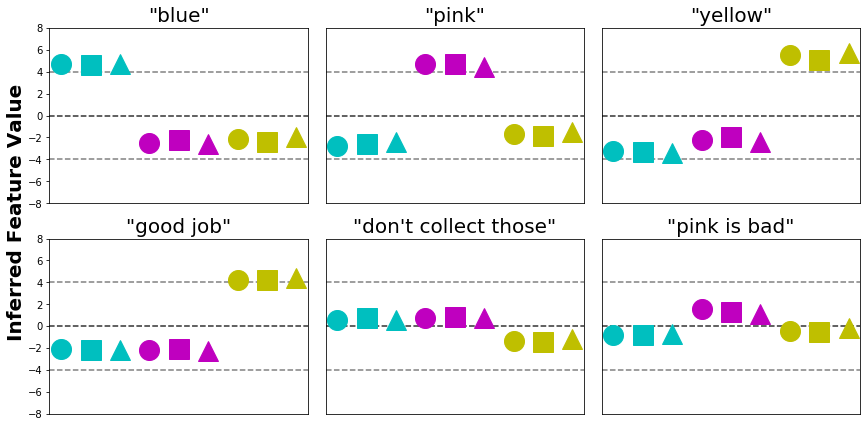

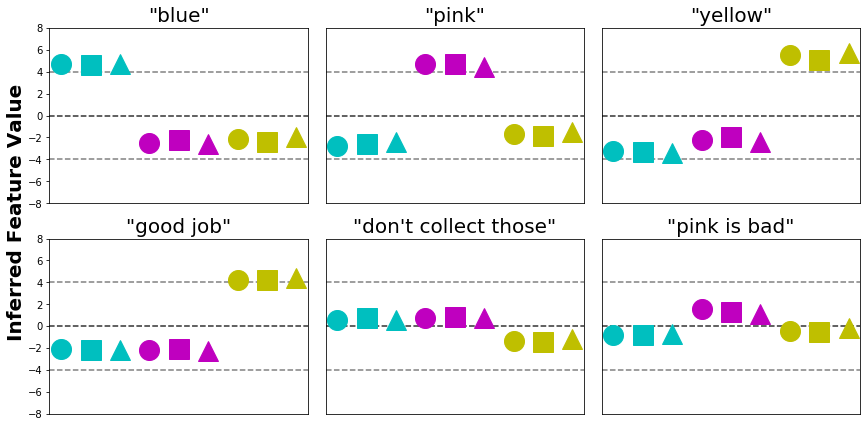

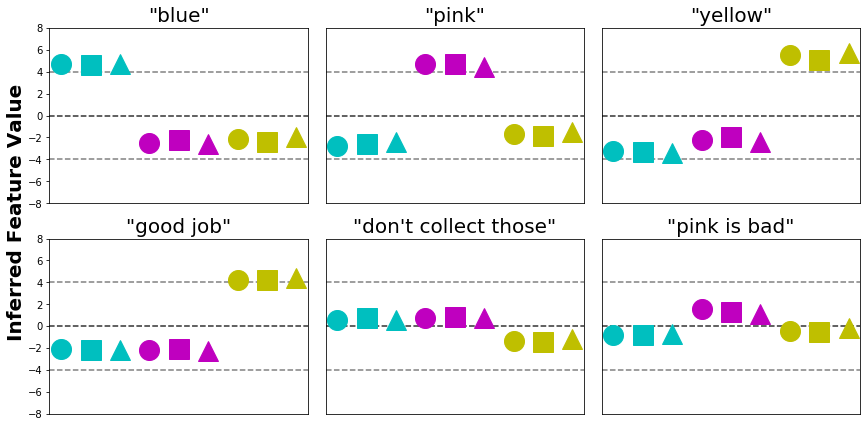

In [44]:
phrases = [ "blue", "pink", "yellow", "good job", "don't collect those", "pink is bad"]

from science.observations.text_analysis import nn_preprocess_chat_phrase
from science.utils import FEATURE_ABBREVIATION_DICT

from science.agents.agents import ExpEnsembleNeuralLearner
inv_map = inv_map = {v: k for k, v in FEATURE_ABBREVIATION_DICT.items()}

fig, axs = plt.subplots(2, 3, figsize=(12, 6))

for i,(ax, phrase) in enumerate(zip(fig.axes, phrases)):
    
    ensemble_learner = ExpEnsembleNeuralLearner()
    ensemble_learner.update_beliefs(phrase, trajectory)
    beliefs = ensemble_learner.belief_state
        
    points = []
    
    for y_val in [-4,  0,  0, 4]:
        ax.axhline(y_val, linestyle='--', color='k', alpha=.5)
    
    for feature in sorted(CONJUNCTIONS):
        color = inv_map[feature.split('|')[0]]
        shape = inv_map[feature.split('|')[1]]
        points.append((beliefs[feature]["mean"], '{}{}'.format(color, shape)))
    for x, point in enumerate(points):
        ax.plot(x, point[0], point[1], markersize=20)
        ax.set_ylim(-8, 8)
    
    ax.get_xaxis().set_ticks([], [])
    ax.set_title("\"{}\"".format(phrase), fontsize=20)
    
    if i not in (0, 3):
        ax.get_yaxis().set_ticks([], [])
    
fig.text(0, 0.5, 'Inferred Feature Value', va='center', rotation='vertical', fontsize="20", fontweight='bold')

plt.tight_layout()
plt.show()